In [5]:
from pathlib import Path
import sys
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

# --------------------------------------------------
# Resolve project root safely (notebooks → project root)
# --------------------------------------------------
BASE_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Make project root importable (for models/, features/, etc.)
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

# --------------------------------------------------
# Define paths
# --------------------------------------------------
FEATURES_PATH = BASE_DIR / "data" / "processed" / "features.parquet"

# --------------------------------------------------
# Safety check
# --------------------------------------------------
assert FEATURES_PATH.exists(), f"Missing features file: {FEATURES_PATH}"

# --------------------------------------------------
# Load features
# --------------------------------------------------
X = pd.read_parquet(FEATURES_PATH)


In [7]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)


In [8]:
from models.autoencoder import Autoencoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Autoencoder(input_dim=X.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)


In [9]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0.0
    for (batch,) in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(loader):.6f}")


Epoch 1, Loss: 0.078281
Epoch 2, Loss: 0.002520
Epoch 3, Loss: 0.001560
Epoch 4, Loss: 0.001469
Epoch 5, Loss: 0.001341
Epoch 6, Loss: 0.000789
Epoch 7, Loss: 0.000727
Epoch 8, Loss: 0.000386
Epoch 9, Loss: 0.000404
Epoch 10, Loss: 0.000256


In [10]:
model.eval()

with torch.no_grad():
    recon = model(X_tensor.to(device))
    recon_error = torch.mean((recon - X_tensor.to(device))**2, dim=1)


In [11]:
ae_scores = recon_error.cpu().numpy()


In [12]:
import numpy as np

threshold = np.percentile(ae_scores, 99)
ae_alerts = ae_scores >= threshold


In [13]:
# Models directory
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Save model
MODEL_PATH = MODELS_DIR / "autoencoder_v1.pt"
torch.save(model.state_dict(), MODEL_PATH)

In [14]:
# Processed data directory
PROCESSED_DIR = BASE_DIR / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Save scores
AE_SCORES_PATH = PROCESSED_DIR / "ae_scores.csv"

pd.DataFrame({
    "ae_score": ae_scores,
    "ae_alert": ae_alerts
}).to_csv(AE_SCORES_PATH, index=False)

In [15]:
# Define path to iForest scores
IFOREST_SCORES_PATH = BASE_DIR / "data" / "processed" / "iforest_scores.csv"

# Optional safety check
assert IFOREST_SCORES_PATH.exists(), f"Missing file: {IFOREST_SCORES_PATH}"

# Load scores
if_scores = pd.read_csv(IFOREST_SCORES_PATH)

In [16]:
comparison = pd.DataFrame({
    "if_score": if_scores["anomaly_score"],
    "ae_score": ae_scores
})


In [17]:
comparison.corr()


,if_score,ae_score
if_score,1.000000,0.274964
ae_score,0.274964,1.000000


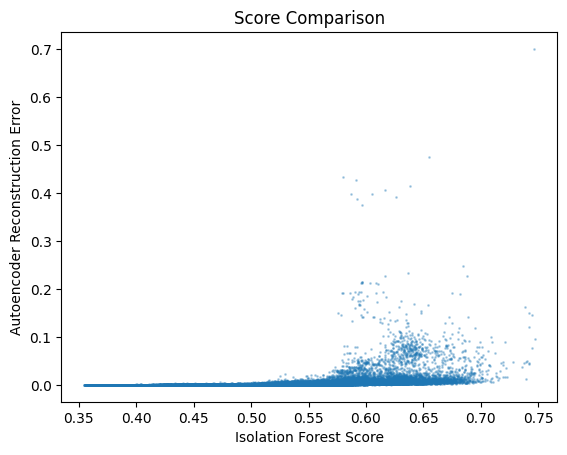

In [18]:
import matplotlib.pyplot as plt

plt.scatter(
    comparison["if_score"],
    comparison["ae_score"],
    alpha=0.3,
    s=1
)
plt.xlabel("Isolation Forest Score")
plt.ylabel("Autoencoder Reconstruction Error")
plt.title("Score Comparison")
plt.show()
